In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Check the availability of GPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

#### Split the folder into train and test and prepare Data Loder

In [4]:
splitfolders.ratio("Circle_Cross", output="TrainTest", seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

In [5]:
train_data = datasets.ImageFolder('TrainTest/train', transform=transform)
test_data = datasets.ImageFolder('TrainTest/val', transform=transform)

In [6]:
train_data

Dataset ImageFolder
    Number of datapoints: 1599
    Root location: TrainTest/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [7]:
test_data

Dataset ImageFolder
    Number of datapoints: 401
    Root location: TrainTest/val
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=32, drop_last=True)

class_names = train_data.classes
class_names, len(train_data), len(test_data)

(['circles', 'crosses'], 1599, 401)

#### Display a batch of images

In [9]:
for images, labels in train_loader:
    break
images.shape
# batch size, channel, size of img (116, 116) --> 4D convert to 2D

torch.Size([32, 3, 116, 116])

In [10]:
labels

tensor([1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 1, 1])

#### image dataset
- Contains images of circles (O) and cross (X)
- size of each image is 116 x 116 (pixels) and is color scale
    - So the input features = 3 x 116 x 116 = 40368 pixels
    - the classes circles (O) and cross (X) = 2 classes

#### Visualize

Label: [1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0 1 1]
Class: ['crosses' 'crosses' 'crosses' 'circles' 'crosses' 'circles' 'circles'
 'crosses' 'circles' 'crosses' 'crosses' 'crosses' 'crosses' 'circles'
 'crosses' 'crosses' 'circles' 'crosses' 'circles' 'circles' 'crosses'
 'crosses' 'circles' 'circles' 'circles' 'circles' 'crosses' 'crosses'
 'circles' 'circles' 'crosses' 'crosses']


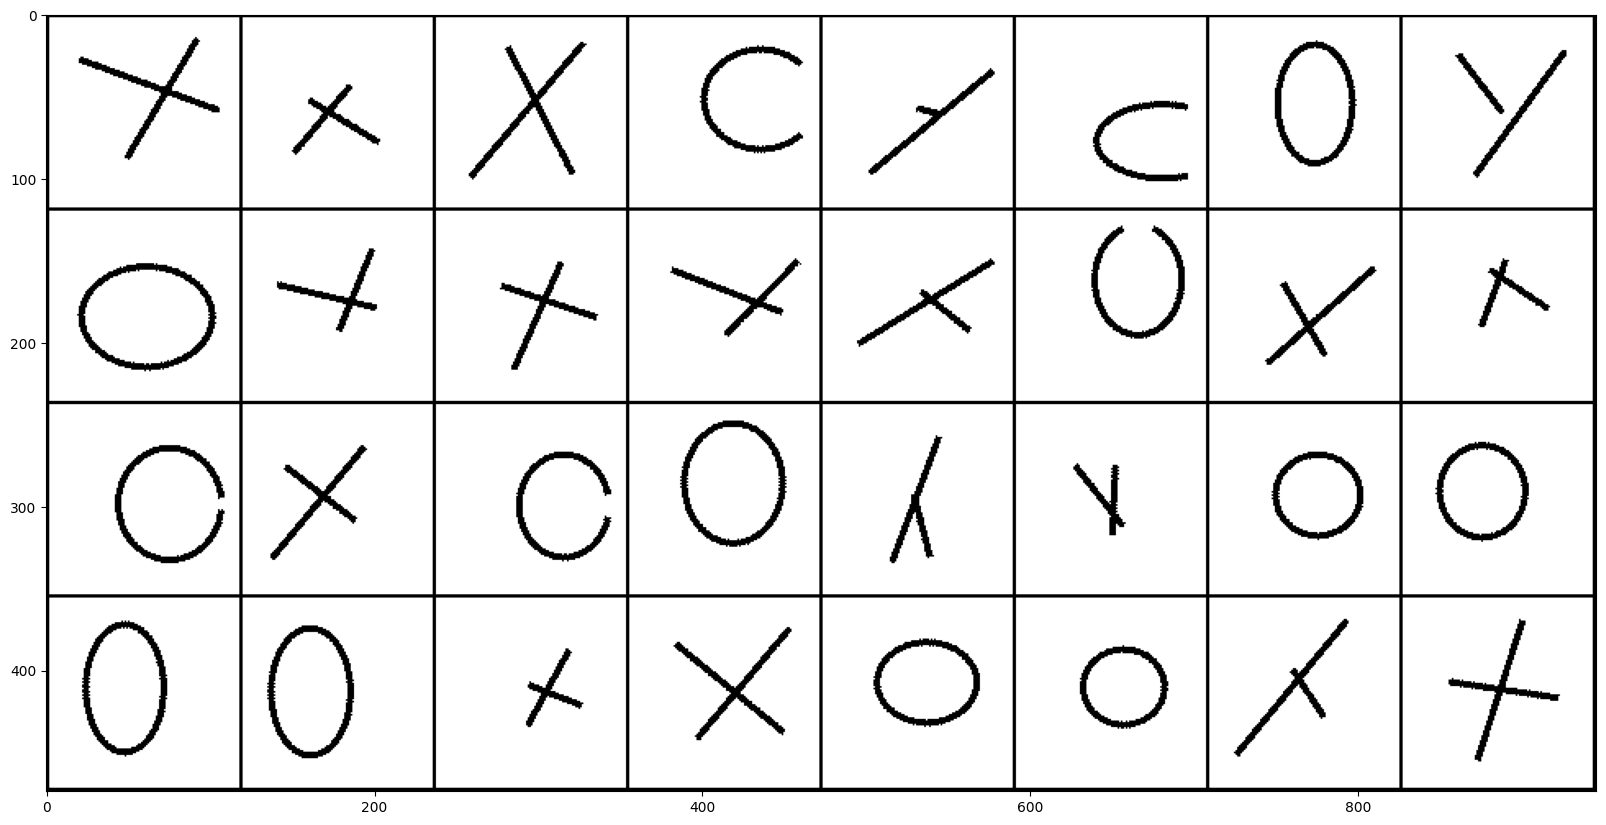

In [11]:
print('Label:', labels.numpy())
print('Class:', np.array([class_names[i] for i in labels]))

im = make_grid(images)
plt.figure(figsize=(20, 16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

#### Define the model

In [12]:
class NN_Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(40368, 2048)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        
        # classification or output layer
        self.output = nn.Linear(64, 2)
    # Forward pass
    def forward(self, x):
        x = self.input(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        # output layer
        x = self.output(x)
        
        return x
model = NN_Classifier()

In [13]:
model

NN_Classifier(
  (input): Linear(in_features=40368, out_features=2048, bias=True)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

#### Train and Test the model

In [14]:
learningRate = 0.001
momentum = 0.9
lossfc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=momentum, lr=learningRate)

In [15]:
epochs = 50
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []

for epoch in range(epochs):
    model.train()
    model.to(device)
    # Loop for training in batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
        X = X.reshape(32, 40368) # Reshape 4D to 2D
        X = X.to(device) # Placing features on device
        y = y.to(device) # placing labels on device
        
        ypred = model(X)
        loss = lossfc(ypred,y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append batchloss
        batchLoss.append(loss.item())
        
        ypred = ypred.cpu() # Back to cpu
        y = y.cpu()
        
        # compute batch accuracy
        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc)
        
    # Average training accuracy (Outside the batchloop)
    trainAcc.append(np.mean(batchAcc))
    
    # Losses through epochs
    losses[epoch] = np.mean(batchLoss)
    
    
    # TESTING the model
    model.eval()
    with torch.no_grad(): #This step  Deactivating autogradient
        for X,y in test_loader:
            X = X.reshape(32, 40368) # Reshape 4D to 2D
            X = X.to(device)
            y = y.to(device)
            ypred = model(X)
            ypred = ypred.cpu()
            y = y.cpu()
        # Appending test accuracy
    testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
    if (epoch % 5) == 0:
        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.69
 epochs : 5  loss :  0.69
 epochs : 10  loss :  0.69
 epochs : 15  loss :  0.69
 epochs : 20  loss :  0.68
 epochs : 25  loss :  0.62
 epochs : 30  loss :  0.15
 epochs : 35  loss :  0.13
 epochs : 40  loss :  0.02
 epochs : 45  loss :  0.21


#### Visualizing the Loss and Accuracies

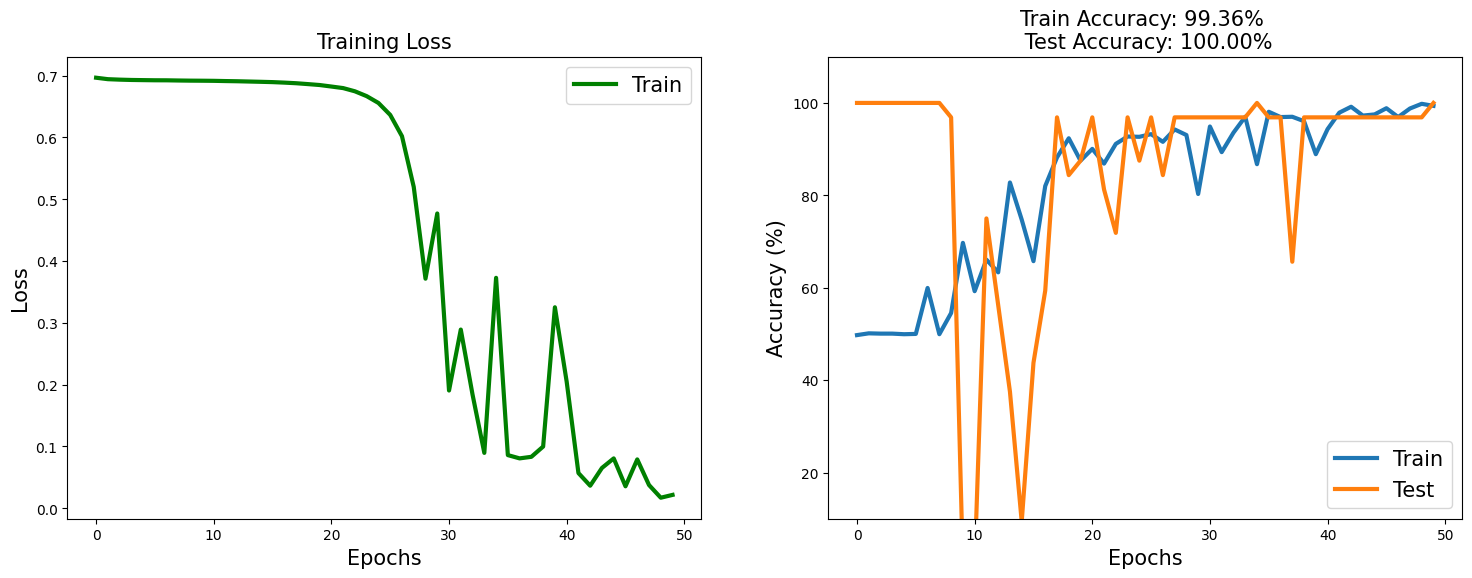

In [16]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

### Classifier with Dropout

In [18]:
class NN_Classifier_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.input = nn.Linear(40368, 2048)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        
        # classification or output layer
        self.output = nn.Linear(64, 2)
    # Forward pass
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc6(x)
        x = F.relu(x)
        x = self.dropout(x)
        # output layer
        x = self.output(x)
        
        return x
model2 = NN_Classifier_Dropout()

In [19]:
model2

NN_Classifier_Dropout(
  (dropout): Dropout(p=0.2, inplace=False)
  (input): Linear(in_features=40368, out_features=2048, bias=True)
  (fc1): Linear(in_features=2048, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

#### Train and Test the model

In [20]:
learningRate = 0.001
momentum = 0.9
lossfc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(), momentum=momentum, lr=learningRate)

In [21]:
epochs = 50
losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []

for epoch in range(epochs):
    model2.train()
    model2.to(device)
    # Loop for training in batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
        X = X.reshape(32, 40368) # Reshape 4D to 2D
        X = X.to(device) # Placing features on device
        y = y.to(device) # placing labels on device
        
        ypred = model2(X)
        loss = lossfc(ypred,y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append batchloss
        batchLoss.append(loss.item())
        
        ypred = ypred.cpu() # Back to cpu
        y = y.cpu()
        
        # compute batch accuracy
        acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
        batchAcc.append(acc)
        
    # Average training accuracy (Outside the batchloop)
    trainAcc.append(np.mean(batchAcc))
    
    # Losses through epochs
    losses[epoch] = np.mean(batchLoss)
    
    
    # TESTING the model
    model2.eval()
    with torch.no_grad(): #This step  Deactivating autogradient
        for X,y in test_loader:
            X = X.reshape(32, 40368) # Reshape 4D to 2D
            X = X.to(device)
            y = y.to(device)
            ypred = model2(X)
            ypred = ypred.cpu()
            y = y.cpu()
        # Appending test accuracy
    testAcc.append(100 * torch.mean((torch.argmax(ypred,dim=1)==y).float()))
    if (epoch % 5) == 0:
        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



 epochs : 0  loss :  0.69
 epochs : 5  loss :  0.69
 epochs : 10  loss :  0.69
 epochs : 15  loss :  0.69
 epochs : 20  loss :  0.69
 epochs : 25  loss :  0.69
 epochs : 30  loss :  0.69
 epochs : 35  loss :  0.64
 epochs : 40  loss :  0.30
 epochs : 45  loss :  0.26


#### Visualizing the Loss and Accuracies

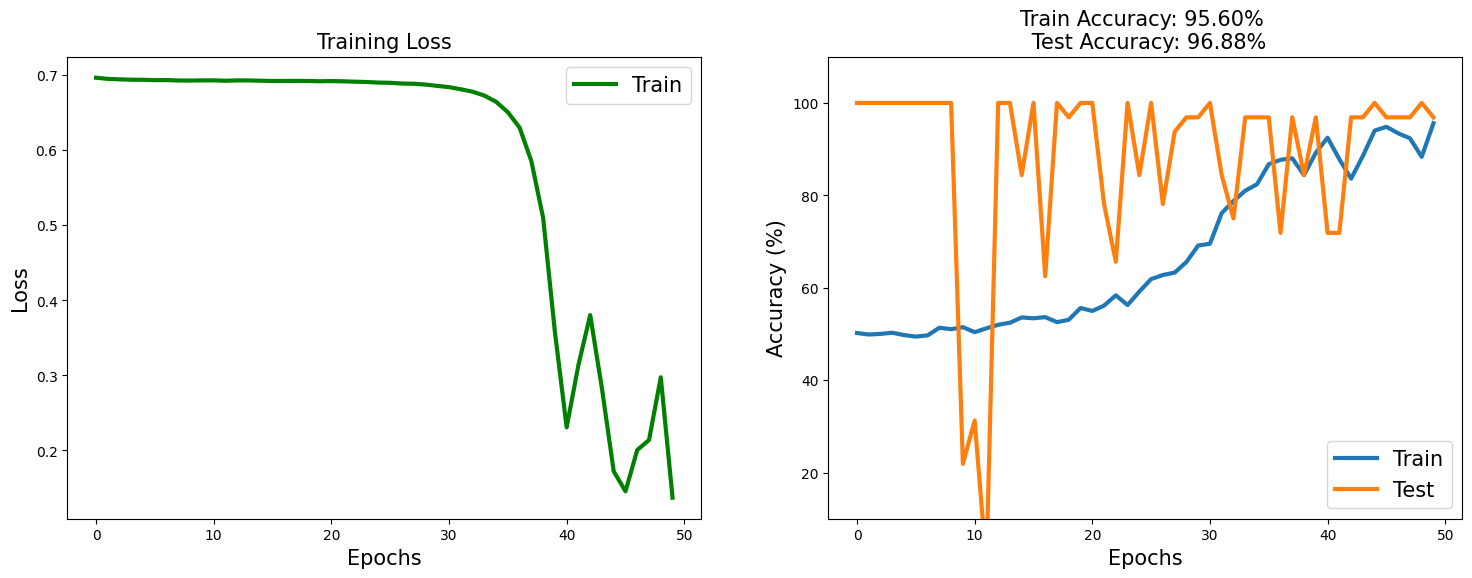

In [22]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()